In [21]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with color jitter and other augmentations
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Brightness adjustment
    preprocessing_function=lambda x: tf.image.random_hue(
        tf.image.random_saturation(
            tf.image.random_contrast(
                tf.image.random_brightness(x, 0.2),
                lower=0.7, upper=1.3
            ),
            lower=0.7, upper=1.3
        ),
        max_delta=0.1
    ),  # Hue adjustment
    fill_mode='nearest',
    validation_split=0.2
)

# Load datasets
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 221 images belonging to 5 classes.
Found 53 images belonging to 5 classes.


In [23]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer

# Directory where images are stored
data_dir = "/home/batch25/Desktop/initial data"

# Initialize lists to store features and labels
X = []
Y = []

# Loop through each class folder and load images
for label in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, label)
    if os.path.isdir(class_folder):
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            try:
                # Load the image and preprocess it
                img = load_img(image_path, target_size=(224, 224))  # Resize to match model input size
                img_array = img_to_array(img)
                X.append(img_array)
                Y.append(label)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)


In [24]:

X = X / 255.0


In [25]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y = lb.fit_transform(Y)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [27]:
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (219, 224, 224, 3)
x_test shape: (55, 224, 224, 3)
y_train shape: (219, 5)
y_test shape: (55, 5)


In [56]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers to retain pre-trained features
base_model.trainable = False

# Add classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [57]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,  # Adjust based on your needs
    batch_size=32
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.2285 - loss: 1.8218 - val_accuracy: 0.4364 - val_loss: 1.3745
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.3961 - loss: 1.4304 - val_accuracy: 0.4727 - val_loss: 1.2893
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5662 - loss: 1.1506 - val_accuracy: 0.4909 - val_loss: 1.1598
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5840 - loss: 1.0427 - val_accuracy: 0.5455 - val_loss: 1.0824
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7455 - loss: 0.8488 - val_accuracy: 0.6364 - val_loss: 1.0527
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.7398 - loss: 0.7562 - val_accuracy: 0.6909 - val_loss: 0.8742
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.7417 - loss: 0.6936 - val_accuracy: 0.6545 - val_loss: 0.9545
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.8101 - loss: 0.5588 - val_accuracy: 0.6727 - val_loss:

In [49]:
# Unfreeze the top 4 layers of MobileNetV2
base_model.trainable = True
fine_tune_at = 100  # Unfreeze all layers from layer index 100 onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after unfreezing layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [50]:
# Train the model with fine-tuning
history_fine_tuned = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,  # Continue for more epochs if necessary
    batch_size=32
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 0.5513 - loss: 1.1839 - val_accuracy: 0.7091 - val_loss: 0.8848
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9112 - loss: 0.3029 - val_accuracy: 0.6000 - val_loss: 1.0085
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.9697 - loss: 0.1842 - val_accuracy: 0.6182 - val_loss: 1.0725
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9926 - loss: 0.0914 - val_accuracy: 0.6364 - val_loss: 1.1043
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 1.0000 - loss: 0.0560 - val_accuracy: 0.6727 - val_loss: 1.1402
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 1.0000 - loss: 0.0487 - val_accuracy: 0.6727 - val_loss: 1.1807
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.9974 - loss: 0.0324 - val_accuracy: 0.6727 - val_loss: 1.1901
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.9982 - loss: 0.0171 - val_accuracy: 0.6727 - val_loss:

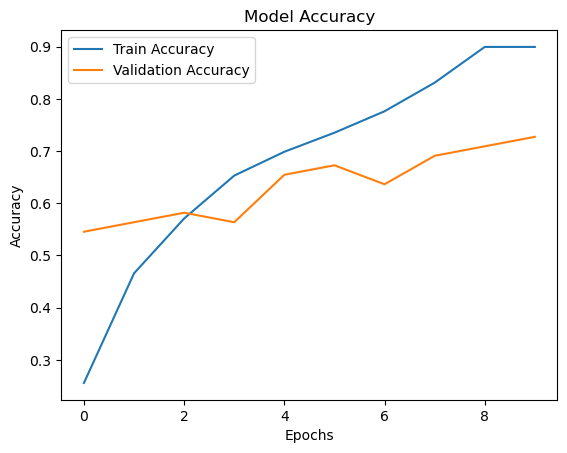

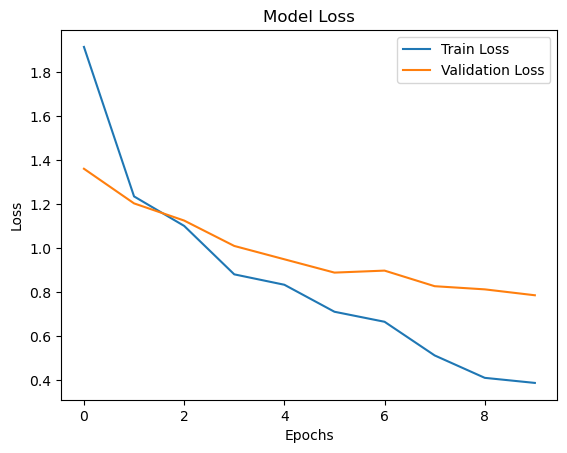

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get model predictions
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report (includes precision, recall, F1-score)
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_))

# Print confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true_classes, y_pred_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Classification Report:

              precision    recall  f1-score   support

           1       0.44      0.89      0.59         9
          10       0.68      0.93      0.79        14
          12       1.00      0.25      0.40         8
          20       0.60      0.82      0.69        11
           5       1.00      0.08      0.14        13

    accuracy                           0.60        55
   macro avg       0.75      0.59      0.52        55
weighted avg       0.75      0.60      0.53        55

Confusion Matrix:

[[ 8  1  0  0  0]
 [ 1 13  0  0  0]
 [ 0  2  2  4  0]
 [ 0  2  0  9  0]
 [ 9  1  0  2  1]]


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get model predictions
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {accuracy:.4f}")

# Precision, Recall, and F1-score (macro average)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Overall Precision (Macro average): {precision:.4f}")
print(f"Overall Recall (Macro average): {recall:.4f}")
print(f"Overall F1-score (Macro average): {f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Overall Accuracy: 0.6000
Overall Precision (Macro average): 0.7457
Overall Recall (Macro average): 0.5925
Overall F1-score (Macro average): 0.5231


In [18]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)))  # Change input shape to (224, 224, 3)
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [17]:
# Configures the model for training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(x_test, y_test))

Epoch 1/5


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 5), output.shape=(None, 10)

In [61]:

from tensorflow.keras.preprocessing import image
import numpy as np

# Function to preprocess the image (resize and normalize)
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to match the model input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image to [0, 1] (same as training)
    return img_array

# Load and preprocess a single image
image_path = '/home/batch25/Desktop/test/2/1d24b0ba8199ef01175d741e224733ae.jpg'  # Provide the path to the single image
test_image = preprocess_image(image_path)

# Predict the class using the trained model
prediction = model.predict(test_image)

# Get the predicted class index
predicted_class_idx = np.argmax(prediction, axis=1)

# Retrieve the class label based on the predicted class index
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_idx[0]]

print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class: 1
